# text2poem
Given a list of topics, generate a related poem

## To-do:
- [ ] Tune the batch size
- [ ] Tune the number of epochs

## Install Dependencies

In [1]:
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

     |████████████████████████████████| 2.1MB 25.8MB/s 
     |████████████████████████████████| 901kB 44.0MB/s 
     |████████████████████████████████| 3.3MB 50.6MB/s 
     |████████████████████████████████| 1.1MB 38.2MB/s 


## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To reset the notebook, run from this point

In [71]:
%reset -f

## Import Libraries

In [72]:
# General libraries
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [73]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Constants

In [74]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/topics_250_top_authors.csv"
MODEL_NAME = "t5-small"

SEED = 42

# Specified in the number of tokens
MAX_LEN = 512
SUMMARY_LEN = 512

TRAIN_BATCH_SIZE = 2
VALID_BATCH_SIZE = 2

N_EPOCHS = 10 # 5 is good enough for 5k samples in data
LR = 3e-4

PREFIX = "poemify: " # The T5 prefix to append to the inputs
SENT_SEP = " | "
TOPIC_SEP = ", "

In [75]:
# Set random seeds and make pytorch deterministic for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Helper Functions

In [76]:
def countParameters(model):
    """ Counts the total number of trainable and frozen parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Data Handlers

In [77]:
def replaceSep(text, sep = SENT_SEP):
    """ Replaces '\n' by sep everywhere, as T5Tokenizer just replaces '\n' by a blank space """
    return text.replace("\n", sep)

In [78]:
def loadDF(path, n_rows = None, prefix = PREFIX):
    """ Loads the CSV data, converts it to the specified format, and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")

    # Drop the NaN rows (if any)
    df.dropna(inplace = True)

    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]

    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)

    # Add a suitable prefix to the text input
    df["input"] = prefix + df["input"]

    # Truncate the dataset if specified
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    # Replace newlines in the poem
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, test_size = 5, random_state = SEED, shuffle = True)
    
    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [79]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, MAX_LEN, SUMMARY_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, MAX_LEN, SUMMARY_LEN)

    # Create Dataloaders
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)

    return dl_train, dl_val

## Custom Dataset

In [80]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len
        self.out_len = out_len

        self.inp_txt = self.df.input
        self.out_txt = self.df.output

    def __len__(self):
        return len(self.out_txt)

    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )
        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source['input_ids'].squeeze()
        source_mask = source['attention_mask'].squeeze()
        target_ids = target['input_ids'].squeeze()
        target_mask = target['attention_mask'].squeeze()

        return {
            'source_ids'  : source_ids.to(dtype = torch.long), 
            'source_mask' : source_mask.to(dtype = torch.long), 
            'target_ids'  : target_ids.to(dtype = torch.long),
            'target_mask' : target_mask.to(dtype = torch.long)
        }

## Train and Validate Functions:

In [81]:
def train(epoch, tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE, dtype = torch.long)
        source_mask = batch["source_mask"].to(DEVICE, dtype = torch.long)
        target_mask = batch["target_mask"].to(DEVICE, dtype = torch.long)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
        
        # Compute gradients
        loss.backward()
        # Update parameters
        optimizer.step()

    return loss.item()

In [82]:
def validate(epoch, tokenizer, model, loader):

    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():

        for iter, data in enumerate(tqdm(loader)) :

            source_ids  = data['source_ids'].to(DEVICE, dtype = torch.long)
            source_mask = data['source_mask'].to(DEVICE, dtype = torch.long)

            generated_ids = model.generate(
                input_ids = source_ids,
                attention_mask = source_mask,
                max_length = SUMMARY_LEN,
                num_beams = 1,
                repetition_penalty = 2.5, 
                # early_stopping = True
            )
            predicted_output = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids]

            target_ids  = data['target_ids'].to(DEVICE, dtype = torch.long)
            true_output = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in target_ids]

            y_pred.extend(predicted_output)
            y_true.extend(true_output)

            if (iter > 5):
                break

    return y_pred, y_true

In [83]:
def generate(topics):

    input = PREFIX + TOPIC_SEP.join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        max_length = 1024,
        num_beams = 1,
        # early_stopping = True,
        no_repeat_ngram_size = 2
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split(SENT_SEP)
    for s in sentences:
        print(s.strip())

    return gen

In [84]:
def genSample(topics, min_length, max_length, rep_penalty, temp = 1):

    input = PREFIX + TOPIC_SEP.join(topics)

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    generated_ids = model.generate(
        input_ids = input_ids,
        min_length = min_length,
        max_length = max_length,
        do_sample = True,
        # top_p = 0.92,
        # top_k = 50,
        temperature = temp,
        repetition_penalty = rep_penalty
    )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split(SENT_SEP)
    for s in sentences:
        print(s.strip())

    return gen

## Main

In [85]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

### Loading the Data

In [86]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = PREFIX)
print(len(df), len(df_train), len(df_val))

566 561 5


In [87]:
display(df)

,output,input
0,I wage not any feud with Death | For changes w...,"poemify: shattered stalks, lower life, human w..."
1,Again at Christmas did we weave | The holly ro...,"poemify: single tear, silent snow, quiet sense..."
2,"Calm is the morn without a sound, | Calm as to...","poemify: deep peace, dead calm, calmer grief, ..."
3,"Risest thou thus, dim dawn, again, | And howle...","poemify: disastrous day, joyless gray, hideous..."
4,"Dark house, by which once more I stand | Here ...","poemify: unlovely street, street breaks, life ..."
...,...,...
561,"From low to high doth dissolution climb, | And...","poemify: over-anxious care, awful notes, melan..."
562,"The power of Armies is a visible thing, | Form...","poemify: fatal place, brave people, strong win..."
563,Most sweet it is with unuplifted eyes | To pac...,"poemify: happy tone, ideal scene, internal hea..."
564,Beneath these fruit-tree boughs that shed | Th...,"poemify: happiest guest, voiceless form, unclo..."


In [88]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

281 3


### Loading the Model

In [89]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [90]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 60,506,624 trainable and 0 frozen parameters


### Optimization

In [91]:
optimizer = Adafactor(
    params = model.parameters(), 
    lr = LR, 
    scale_parameter = False, 
    relative_step = False
)

In [92]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}")
    loss_epoch = train(e, tokenizer, model, dl_train, optimizer)
    losses.append(loss_epoch)

Epoch 1



Epoch 2



Epoch 3



Epoch 4



Epoch 5



Epoch 6



Epoch 7



Epoch 8



Epoch 9



Epoch 10


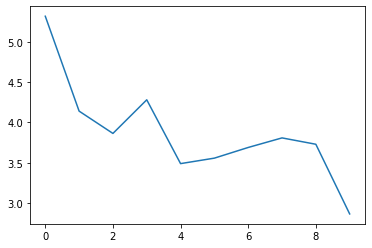

In [93]:
plt.plot(range(len(losses)), losses)
plt.show()

In [94]:
predictions, actuals = validate(0, tokenizer, model, dl_val)
results = pd.DataFrame({'Generated Text' : predictions, 'Actual Text' : actuals})

In [95]:
display(results)

,Generated Text,Actual Text
0,"I am a poet, and never was the man. | And when...",I think it better that in times like these | A...
1,"I heard the roaring winds of this night, | And...","The wild winds weep, | And the night is a-cold..."
2,"The throstle singers, | And the sweet evening ...","Up! up! my Friend, and quit your books; | Or s..."
3,"I heard the ghost of a murderer doe, | And tha...","So, so breake off this last lamenting kisse, |..."
4,"I heard a song of fresh images, | And the nigh...",The unpurged images of day recede; | The Emper...


In [96]:
x = 4
print(results.iloc[x]["Generated Text"], "\n")
print(results.iloc[x]["Actual Text"])

I heard a song of fresh images, | And the night resonance recedes in my scorn aloud. | The moonlit dome is lit with bitter furies; and it was not to be:-It had been no more! But when we were young they did hear them feeds on me 

The unpurged images of day recede; | The Emperor's drunken soldiery are abed; | Night resonance recedes, night-walkers' song | After great cathedral gong; | A starlit or a moonlit dome disdains | All that man is, | All mere complexities, | The fury and the mire of human veins. | | Before me floats an image, man or shade, | Shade more than man, more image than a shade; | For Hades' bobbin bound in mummy-cloth | May unwind the winding path; | A mouth that has no moisture and no breath | Breathless mouths may summon; | I hail the superhuman; | I call it death-in-life and life-in-death. | | Miracle, bird or golden handiwork, | More miracle than bird or handiwork, | Planted on the starlit golden bough, | Can like the cocks of Hades crow, | Or, by the moon embittere

In [97]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.3, 0.9)

The snow falls on the pine forest,
A weeping air is rolate in the wind.
I think my tree has been desolate and doth lie;
We are very happy with it's side of the wood:
And when you were weeping there was some rustling cloud,
That would make me sad to see?
Or did I wonder why that pew-water again (you may have heard this through the last few days),
So much as a valley such as the arctic lake)
But what does one look like if they thought about it


In [98]:
gen = genSample(["tree", "weeping", "rustling", "forest", "wind", "desolate"], 100, 500, 1.4, 0.7)

I walked the forest with our own wind
And weeping it in forests, and found its way back.
So long ago I went again; but now my feet were still dewled:
In that particular tree suddenly came away!
The sun was falling off to me,-but none did move from me.
But a little more amused by this wind (to be seen) then she fell down as far forward without cause on you.
As for some reason why I turned out of love


In [99]:
gen = genSample(["happy", "elated smile", "beautiful eyes"], 100, 500, 1.3, 0.9)

I am happy and elated smile in the eyes,
Which one we attracted to us was such an eye. The face of our day was so beautiful as possible;
So happy with a smile that stood beyond my feet:
And looked like an angel's eye, or just an apple!
Love, for love, joy, happiness and laughter are two things that make me feel:
When you look from above your eyes by yourself,
You have been one who has wished there before


In [100]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.5, 0.9)

I'm glad, as the glowing sun shines;
As in an elated smile at some dance trees come joyous.
| And when you see on your feet like lightning or snow,
That blooming sky with happy faces lies:
For that they have gone down here is my voice and glow.
What did we hear of this? No! When was it something else...
It became so much joyous than not to forget about their smiling faces)
We were all touched by dancing trees


In [101]:
gen = genSample(["glowing sun", "happy faces", "dancing trees", "joyous", "elated smile"], 100, 500, 1.4)

I thought, like the balding trees of the world!
When my happy faces had moved by in joyous form.
O cheered that day upon me; but when I saw it again:
And we came along with dancing trees, and then was walking for work-torns;
By this shining sun all smiled at your feet...ay as you walk,
Where even more joyful than those to touch him?
Oh do not wear his eyes alone, or kiss her face,
With laughter only which would make them laugh


In [102]:
gen = genSample(["hoary sky", "consistent light", "long time", "taking", "silly" ,"back", "animals", "tired"], 100, 500, 1.4, 0.8)

Why do you know how tired I is?
While the animal has gotten wetter, and now my hoary sky is gone.
The sun has been gothic with constant light in one long time;
As for me it was silly to look back on us, but so many of them were all foolish:
But after that I had no idea where they will be taking him there too!
That did not mean why this image would pass southward upon our bones


## Dummy cells added by the script
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```